In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Load dataset
df = pd.read_csv(r'Datasets/set2_500_patients.csv', sep=';')

# Add a new 'death' target variable
df['death'] = df['action'].apply(lambda x: 1 if x == "patient died" else 0)

# Optionally, you can assume that a heart attack could lead to death.
df['death'] = df.apply(lambda row: 1 if row['heart_attack'] == 1 else row['death'], axis=1)

# Features and targets
features = df.drop(['heart_attack', 'accident', 'death'], axis=1)
target_heart_attack = df['heart_attack']
target_accident = df['accident']
target_death = df['death']

# Categorical and numerical features
categorical_features = ['action']
numerical_features = ['day', 'hour', 'alertness', 'hypertension', 'intoxication',
                      'smoker', 'overweight', 'family_history', 'goof_ball', 'subject']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipelines for each target
pipeline_heart_attack = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_accident = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_death = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))  # Handle imbalance for death
])

# Train-test split
X_train, X_test, y_train_heart_attack, y_test_heart_attack = train_test_split(
    features, target_heart_attack, test_size=0.3, random_state=42)
X_train_accident, X_test_accident, y_train_accident, y_test_accident = train_test_split(
    features, target_accident, test_size=0.3, random_state=42)
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(
    features, target_death, test_size=0.3, random_state=42)

# Fit the models
pipeline_heart_attack.fit(X_train, y_train_heart_attack)
pipeline_accident.fit(X_train_accident, y_train_accident)
pipeline_death.fit(X_train_death, y_train_death)

# Predictions
y_pred_heart_attack = pipeline_heart_attack.predict(X_test)
y_pred_accident = pipeline_accident.predict(X_test_accident)
y_pred_death = pipeline_death.predict(X_test_death)

# Predictions on new data
new_data = pd.read_excel(r'Datasets/set3_500_patients.xlsx')
new_data_features = new_data[numerical_features + categorical_features]

predicted_heart_attack = pipeline_heart_attack.predict(new_data_features)
predicted_accident = pipeline_accident.predict(new_data_features)
predicted_death = pipeline_death.predict(new_data_features)

new_data['predicted_heart_attack'] = predicted_heart_attack
new_data['predicted_accident'] = predicted_accident
new_data['predicted_death'] = predicted_death
new_data.to_csv(r'Predictions/predicted_results_with_death.csv', sep=';', index=False)

print("Predictions with death saved to 'predicted_results_with_death.csv'")


Predictions with death saved to 'predicted_results_with_death.csv'


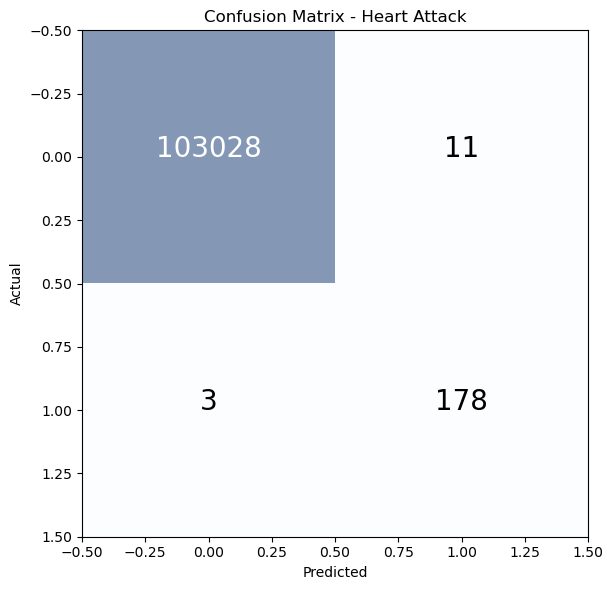

Heart Attack Metrics:
Accuracy: 1.00
Sensitivity (Recall): 0.98
Specificity: 1.00




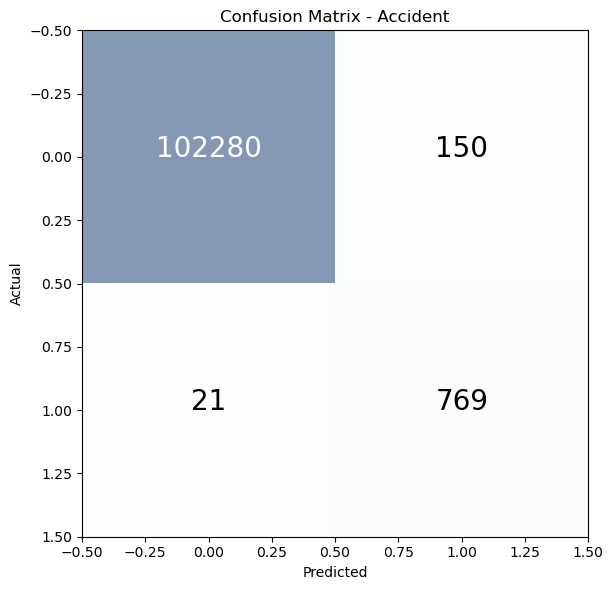

Accident Metrics:
Accuracy: 1.00
Sensitivity (Recall): 0.97
Specificity: 1.00




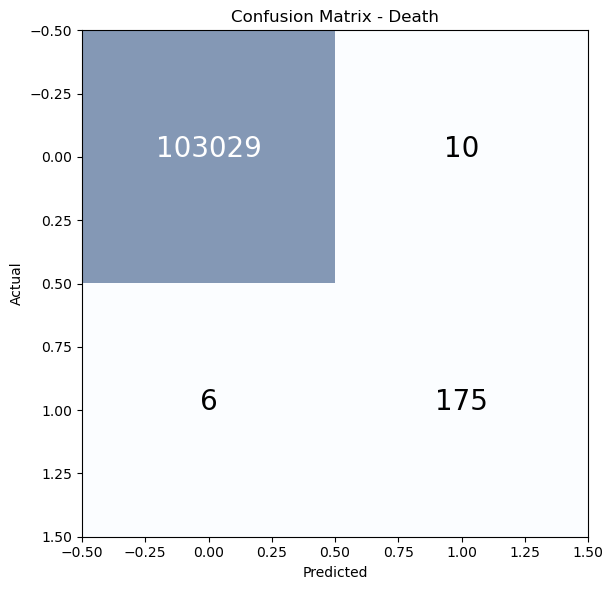

Death Metrics:
Accuracy: 1.00
Sensitivity (Recall): 0.97
Specificity: 1.00




In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, alpha=0.5)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Add raw numbers to the plot
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20)
    
    plt.tight_layout()
    plt.show()

    # Calculate and print metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"{title} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity (Recall): {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print("\n")

# Plotting confusion matrices
plot_confusion_matrix(y_test_heart_attack, y_pred_heart_attack, "Heart Attack")
plot_confusion_matrix(y_test_accident, y_pred_accident, "Accident")
plot_confusion_matrix(y_test_death, y_pred_death, "Death")